The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


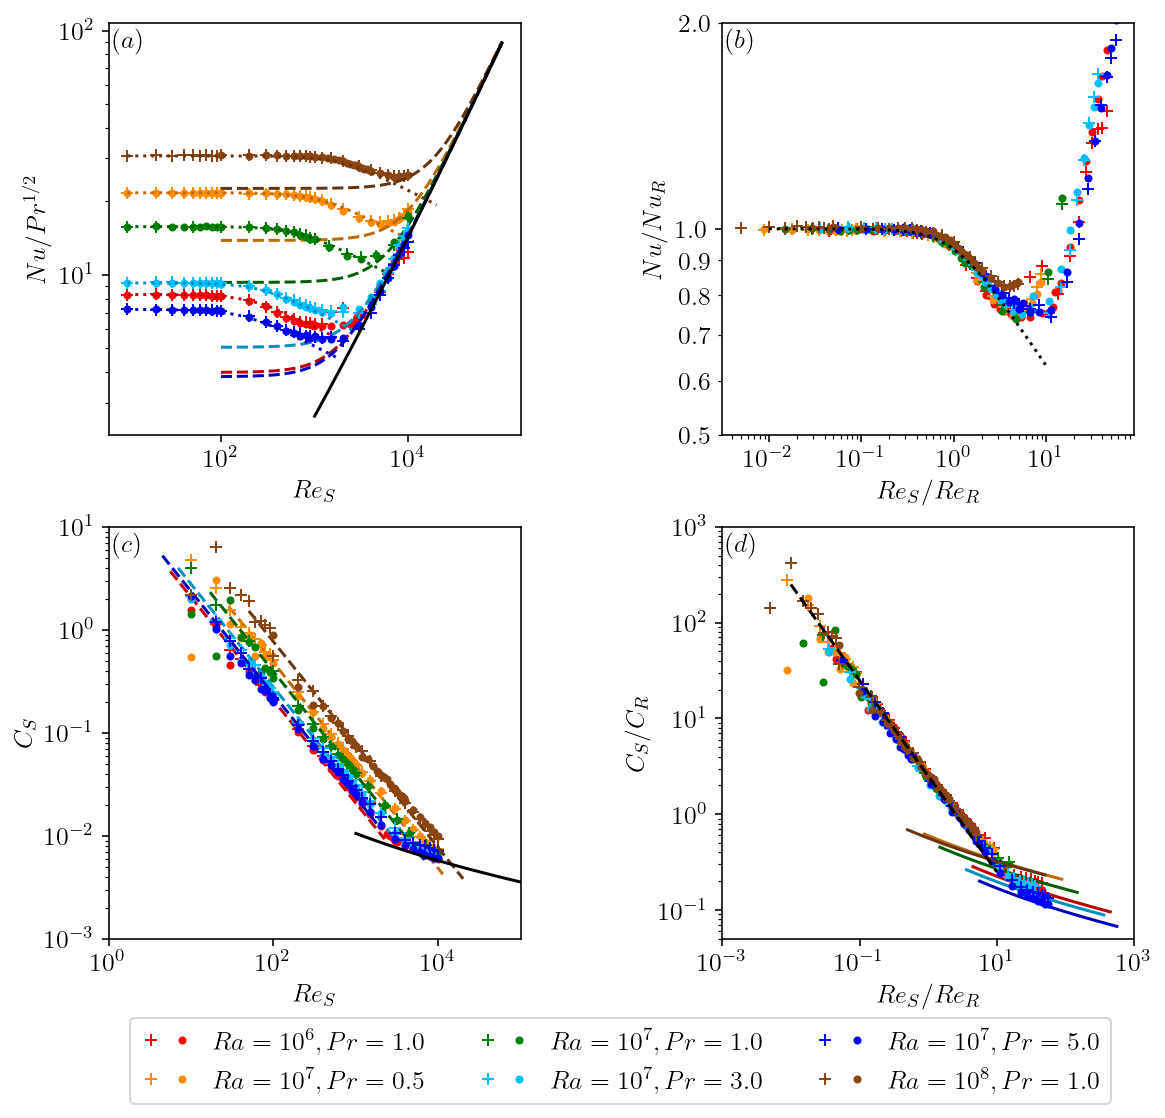

In [3]:
import os
import numpy as np
import scipy.integrate as intg
import scipy.optimize as sopt
import h5py
import matplotlib.pyplot as pl
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import to_rgba
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter

from matplotlib import rc
rc('font',**{'family':'STIXGeneral','serif':['stix'],'size':13})
rc('text', usetex=True)

################################################################

def CF2RE(Cf,kappa=0.41,B=5):

    Aa = (2/Cf)**0.5
    Kk = kappa*(Aa-B)

    return(2*Aa*np.exp(Kk))

def RE2CF(Re,kappa=0.41,B=5,iter=1E4,residual=1E-8,verbose=False):

    Nn = int(np.log10(iter))+1

    # Initial guess
    Cf = 0.060*Re**(-0.25)

    for i in range(int(iter)):
        Aa = (2/Cf)**0.5
        Ik = 1/kappa
        Nr = (Ik*np.log(0.5*Re/Aa)) + B - Aa
        Dr = 0.25*Aa*((Ik*Aa) + (Aa*Aa))
        Cc = Cf - Nr/Dr
        L2 = (np.mean((Cc-Cf)**2))**0.5
        Cf = Cc 
        if verbose: print('Iteration {:{Nn}d}, Residual = {}'.format(i,L2,Nn=int(np.log10(iter))+1))
        if (L2<residual): break
        return(Cf)
    
################################################################

PCF_data = h5py.File('../processed_data/PCF.h5','r')
PPF_data = h5py.File('../processed_data/PPF.h5','r')
RBP_data = h5py.File('../processed_data/RBP.h5','r')
CRB_data = h5py.File('../processed_data/CRB.h5','r')
PRB_data = h5py.File('../processed_data/PRB.h5','r')

Cases = [
    [1E6,1.0],
    [1E7,0.5],
    [1E7,1.0],
    [1E7,3.0],
    [1E7,5.0],
    [1E8,1.0],
]

Case_colors = ['r','darkorange','g','deepskyblue','b','saddlebrown']


fig,axs = pl.subplots(2,2,figsize=(8.5,7),constrained_layout=True)

lbs = []
lts = []

for i,(Case,Case_color) in enumerate(zip(Cases,Case_colors)):

    Ra = Case[0]
    Pr = Case[1]

    Ix_RBP = np.intersect1d(np.argwhere(RBP_data['Rayleigh'][()]==Ra),np.argwhere(RBP_data['Prandtl'][()]==Pr))
    Ix_CRB = np.intersect1d(np.argwhere(CRB_data['Rayleigh'][()]==Ra),np.argwhere(CRB_data['Prandtl'][()]==Pr))
    Ix_PRB = np.intersect1d(np.argwhere(PRB_data['Rayleigh'][()]==Ra),np.argwhere(PRB_data['Prandtl'][()]==Pr))

    Rw_CRB = CRB_data['Wall Reynolds'][Ix_CRB]
    Rc_PRB = PRB_data['Centerline Reynolds'][Ix_PRB]
    Rb_PRB = PRB_data['Bulk Reynolds'][Ix_PRB]
    
    Nu_RBP = RBP_data['Nusselt (stafield)'][Ix_RBP]
    Nu_CRB = CRB_data['Nusselt (stafield)'][Ix_CRB]
    Nu_PRB = PRB_data['Nusselt (stafield)'][Ix_PRB]

    Re_RBP = RBP_data['RMS Reynolds (stafield)'][Ix_RBP]
    Rk_CRB = CRB_data['RMS Reynolds (stafield)'][Ix_CRB]
    Re_PRB = PRB_data['RMS Reynolds (stafield)'][Ix_PRB]

    Rt_CRB = CRB_data['Friction Reynolds (stafield)'][Ix_CRB]
    Rt_PRB = PRB_data['Friction Reynolds (stafield)'][Ix_PRB]

    Rk_RBP = (Ra**(1/2))*(Pr**(-5/6))
    Cf_RBP = Nu_RBP/Re_RBP

    Re_CRB = ((Rk_CRB**2) + (Rw_CRB**2))**0.5
    Cf_CCC = RE2CF(Rw_CRB)
    Cf_CRB = 8*Rt_CRB*Rt_CRB/(Rw_CRB*Rw_CRB)
    
    Rk_PRB = ((Re_PRB**2) - (Rb_PRB**2))**0.5
    Cf_PPP = RE2CF(Rb_PRB)
    Cf_PRB = 8*Rt_PRB*Rt_PRB/(Rb_PRB*Rb_PRB)

    Cf_RBP = Nu_RBP/(Re_RBP*(Pr**(1/3)))

    Re_lm  = 10**np.linspace(-1.6,1,131)
    Cf_lm  = (2.5)*Re_lm**-1

    Re_tb  = 10**np.linspace(3,5,101)
    Cf_tb  = RE2CF(Re_tb)

    R1 = 10**np.linspace(2,5,151)
    R1_CRB = ((R1**2) + (3.2*Ra*Pr**-1.5))**0.5
    CF_CRB = RE2CF(R1_CRB)

    Rr = np.log10(Re_RBP*10)
    R2 = 10**np.linspace(1,Rr,151)
    N2 = Nu_RBP*((1+((R2/Re_RBP)**2))**(-1/10))

    C1 = to_rgba(Case_color)
    Cb = (0,0,0,1)
    C2 = (0.75*np.array(C1) + 0.25*np.array(Cb))

    axs[0,0].plot(Rb_PRB,Nu_PRB/(Pr**0.5),color=C1,marker='+',linestyle='')
    axs[0,0].plot(Rw_CRB,Nu_CRB/(Pr**0.5),color=C1,marker='.',linestyle='')
    axs[0,0].plot(R1,0.25*R1_CRB*CF_CRB,color=C2,marker='',linestyle='--')
    axs[0,0].plot(R2,N2/(Pr**0.5),color=C2,marker='',linestyle=':')

    axs[0,1].plot(Rb_PRB/Re_RBP,Nu_PRB/Nu_RBP,color=C1,marker='+',linestyle='')
    axs[0,1].plot(Rw_CRB/Re_RBP,Nu_CRB/Nu_RBP,color=C1,marker='.',linestyle='')

    axs[1,0].plot(Re_lm*Re_RBP,Cf_lm*Cf_RBP,color=C2,linestyle='--')
    axs[1,0].plot(Rw_CRB,Cf_CRB,color=C1,marker='.',linestyle='')
    axs[1,0].plot(Rb_PRB,Cf_PRB,color=C1,marker='+',linestyle='')
    
    axs[1,1].plot(Re_tb/Re_RBP,Cf_tb/Cf_RBP,color=C2,linestyle='-')
    axs[1,1].plot(Rw_CRB/Re_RBP,Cf_CRB/Cf_RBP,color=C1,marker='.',linestyle='')
    axs[1,1].plot(Rb_PRB/Re_RBP,Cf_PRB/Cf_RBP,color=C1,marker='+',linestyle='')
    
    lb0, = axs[0,0].plot([],[],color=C1,marker='+',linestyle='')
    lb1, = axs[0,0].plot([],[],color=C1,marker='.',linestyle='')
    lbs += [(lb0,lb1)]
    lts += [r'$Ra=10^{:.0f},Pr={:.1f}$'.format(np.log10(Ra),Pr)]

################################################################

Re_tb = 10**np.linspace(3,5,101)
Cf_tb = RE2CF(Re_tb)

Re_lm = 10**np.linspace(1,4,101)
Cf_lm = 0.35*Re_lm**-0.5

axs[0,0].plot(Re_tb,0.25*Cf_tb*Re_tb,linestyle='-',color='k',marker='')

axs[0,0].set_xlabel(r'$Re_S$')
axs[0,0].set_ylabel(r'$Nu/Pr^{1/2}$')

axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')

axs[0,0].text(0.01,0.94,r'$(a)$',transform=axs[0,0].transAxes)

axs[0,0].set_box_aspect(1)

################################################################

Re_by = 10**np.linspace(-2,1,151)
Nu_b1 = (1+(Re_by**2))**(-1/10)

axs[0,1].plot(Re_by,Nu_b1,linestyle=':',color='k',marker='')

axs[0,1].set_ylim(0.5,2.0)

axs[0,1].set_xlabel(r'$Re_S/Re_R$')
axs[0,1].set_ylabel(r'$Nu/Nu_R$')

axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[0,1].yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))

axs[0,1].text(0.01,0.94,r'$(b)$',transform=axs[0,1].transAxes)

axs[0,1].set_box_aspect(1)

################################################################

Re_tb = 10**np.linspace(3,5,101)
Cf_tb = RE2CF(Re_tb)

axs[1,0].plot(Re_tb,Cf_tb,'k-')

axs[1,0].set_xlim(1e0,1e5)
axs[1,0].set_ylim(1e-3,1e1)

axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

axs[1,0].set_xlabel(r'$Re_S$')
axs[1,0].set_ylabel(r'$C_S$')

axs[1,0].text(0.01,0.94,r'$(c)$',transform=axs[1,0].transAxes)

axs[1,0].set_box_aspect(1)

################################################################

Re_lm = 10**np.linspace(-2,1,151)
Cf_lm = (2.5)*Re_lm**-1

axs[1,1].plot(Re_lm,Cf_lm,'k--')

axs[1,1].set_xlim(1e-3,1e3)
axs[1,1].set_ylim(5e-2,1e3)

axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')

axs[1,1].set_xlabel(r'$Re_S/Re_R$')
axs[1,1].set_ylabel(r'$C_S/C_R$')

axs[1,1].text(0.01,0.94,r'$(d)$',transform=axs[1,1].transAxes)

axs[1,1].set_box_aspect(1)

pl.figlegend(lbs,lts,loc='lower center',ncol=3,bbox_to_anchor=(0.5,-0.1),handler_map={tuple: HandlerTuple(ndivide=None)})
# pl.savefig('NuCs.png',dpi=300,bbox_inches='tight')
# pl.savefig('NuCs.pdf',dpi=300,bbox_inches='tight')
# pl.savefig('NuCs.eps',dpi=300,bbox_inches='tight')
pl.show()